# Разбор ДЗ3

1.Попробуйте обучить нейронную сеть на TensorFlow 2 на любом датасете (fachion_mnist, imdb_reviews, boston_housing ). Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

*2. Поработайте с документацией TensorFlow 2. Найдите полезные команды не разобранные на уроке.

3. Постройте сеть на Dense слоях с использование нескольких нитей графа вычислений. (concatenate, Add, .…)

In [ ]:
# The full neural network code!
###############################
import numpy as np
import pandas as pd
#import mnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing



In [ ]:
x = tensorflow.constant([[1, 2, 3], [4, 5, 6]])
tensorflow.transpose(x)



<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]], dtype=int32)>

In [ ]:
x = tensorflow.Variable(tensorflow.random.uniform([5, 3], 0, 10))
x

<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[4.56048  , 2.0489585, 2.2623491],
       [2.047168 , 3.0145276, 6.9125757],
       [9.738837 , 2.1307564, 4.761648 ],
       [6.6235104, 2.9567337, 6.415663 ],
       [8.442517 , 4.289179 , 8.820345 ]], dtype=float32)>

In [ ]:
s0, s1, s2 = tensorflow.split(tensorflow.round(x), num_or_size_splits=3, axis=1)
tensorflow.shape(s0).numpy()

array([5, 1], dtype=int32)

In [ ]:
y, idx = tensorflow.unique(tensorflow.squeeze(s0))
y,idx

(<tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 5.,  2., 10.,  7.,  8.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 2, 3, 4], dtype=int32)>)

In [ ]:
tensorflow.math.cos(s0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.28366217],
       [-0.4161468 ],
       [-0.8390715 ],
       [ 0.75390226],
       [-0.14550003]], dtype=float32)>

Задача регрессии !!!!!!

Можно обрабатывать данные - это улучшит результат. 

Пропускаю этот этап и пойду строить сеть сразу.

In [ ]:
(train_data,train_labels),(test_data,test_labels)=boston_housing.load_data()
#

In [ ]:
# соберу генерацию модели в функцию
def neuron_net(layerList = [10,5]):
  # в функцию в списке передаю число нейронов по слоям (сразу знаем сколько будет слоев и нейронов в них)
  # Используеv функциональное API
  # первый слой всегда 13 входов
  # сеть будет иметь 2 нити - первая нить изменяемая по layerList, вторая нить всегда содержит один полносвязный слой с 5-ю нейронами (это х2)
  first_input = tensorflow.keras.layers.Input(shape=(13, ))
  x1 = Dense(layerList[0], activation='relu')(first_input) # первая нить
  x2 = Dense(5, activation='relu')(first_input) # вторая нить
  for i in range(len(layerList)-1):
    # число скрытых слоев определим автоматом по длине списка layerList, а число нейронов берем из этого списка по порядку
    x1 = Dense(layerList[i+1], activation='relu')(x1)
  merge_two = tensorflow.keras.layers.concatenate([x1, x2])
  out_all = Dense(1, activation='linear')(merge_two)
  # последний слой всегда 1 выход и линейная активация - такая задача - регрессия
  model = tensorflow.keras.models.Model(inputs=[first_input], outputs=out_all)
  # Compile the model. метрику и лосс определяю по регрессии
  model.compile(optimizer='adam', loss='mse',  metrics=['mse'])
  return model

In [ ]:
### Эксперимент
epochs = 100
Error_exp_ = pd.DataFrame(data=np.array([[0,0,0,0,0]]),columns = ['neuron','batch_size','epoch','error','val_mse'])
ik=0
for neuron_ in [64,128,256]:
  # меняю число нейронов скрытого слоя
  #print(neuron_)
  for batch_size_ in [10, 50,100]:
    # меняю размер пакета для обучения
    eerors = []
    acc =[]
    for j in range(3):
      # будем делать несколько перезапусков - сейчас 3
      
      # создаем сеть
      model = neuron_net(layerList = [neuron_,64])
      # учим сеть и проверяем сразу, т.к. включаю validation_split=0.2
      history = model.fit(train_data, train_labels, epochs=5, batch_size=32, validation_data=(test_data,test_labels), verbose=0)
      # записываю результаты валидации, а не обучения - это честно
      eerors.append(history.history['val_loss'][-1])
      acc.append(history.history['val_mse'][-1])
    # Табличка !!!! 
    Error_exp_.loc[ik,['neuron','batch_size','epoch','error','val_mse']] = [neuron_,batch_size_,epochs ,np.mean(eerors),np.mean(acc)]
    ik +=1


# Predict on the first 5 test images.
predictions = model.predict(test_data[:5])

# Print our model's predictions.
print(predictions) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]

[[14.953605]
 [25.11012 ]
 [31.146982]
 [19.024776]
 [29.331923]]
[ 7.2 18.8 19.  27.  22.2]


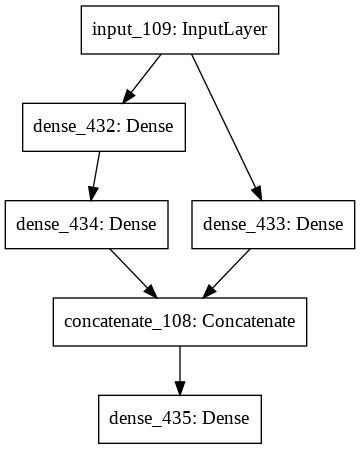

In [ ]:
# Покажем наше чудовище
tensorflow.keras.utils.plot_model(model ,to_file='new_model.png')

In [ ]:
# табличка !!!!
Error_exp_

,neuron,batch_size,epoch,error,val_mse
0,64.0,10.0,100.0,94.859019,73.920517
1,64.0,50.0,100.0,96.472529,78.352320
2,64.0,100.0,100.0,86.874357,72.053684
3,128.0,10.0,100.0,91.933932,76.434591
4,128.0,50.0,100.0,94.745115,64.815578
5,128.0,100.0,100.0,109.994695,72.253742
6,256.0,10.0,100.0,90.287417,63.613831
7,256.0,50.0,100.0,94.281530,62.970320
8,256.0,100.0,100.0,96.466220,68.955372


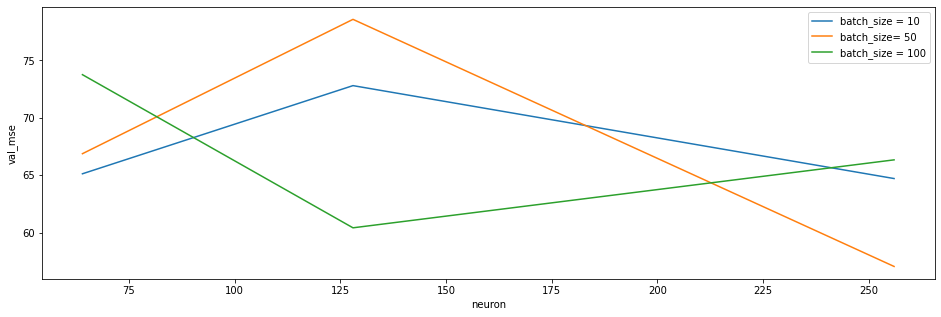

In [ ]:
import matplotlib.pyplot as plt

# ГРАФИКИ !!!!! - это будет точность от числа нейронов по размерам пакетов(batch_size)
e1 = Error_exp_.loc[Error_exp_['batch_size']==10,['neuron','val_mse']]
e2 = Error_exp_.loc[Error_exp_['batch_size']==50,['neuron','val_mse']]
e3 = Error_exp_.loc[Error_exp_['batch_size']==100,['neuron','val_mse']]
plt.figure(figsize=(16,5))

plt.xlabel('neuron')
plt.ylabel('val_mse')
plt.plot(e1['neuron'],e1['val_mse'],label = 'batch_size = 10')
plt.plot(e2['neuron'],e2['val_mse'],label = 'batch_size= 50')
plt.plot(e3['neuron'],e3['val_mse'],label = 'batch_size = 100')
plt.legend()
plt.show()

# Анализ сводной таблицы и графики :

 - Нужно сделать больше экспериментов и посмотреть на конструкцию модели еще как-то :) 


# Рекомендации:

Думаем над задачей - возможно в выделении нитей есть смысл (здесь похоже не было)

нейронки работают от случайной начальной точки - делаем много перезапусков для анализа архитектуры и осредняем результаты

нейронки работают от случайной начальной точки - делаем много перезапусков дляпоиска лучшего варианта, если делаем обучение для работы

Делаем таблички и графики

Проводим анализ результатов: оцениваем средние ошибки(точности) архитектур и дисперсии ошибок (точности) - потом делаем выводы!!

Для этой задачи можно проверить влияние размера выборки, включать/выключать нормализацию данных, проверить поведение по числу эпох, изменять параметры оптимизатора, брать разные активации, разное число слоев, разный loss и т.п.